In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 832)
(466039, 1)
validation
(80707, 832)
(80707, 1)
test
(46831, 832)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:14 - loss: 0.0709 - STD: 1.4243e-04 - MAE: 0.2545

 3/47 [>.............................] - ETA: 1s - loss: 0.0389 - STD: 4.1059e-04 - MAE: 0.1498  

 5/47 [==>...........................] - ETA: 9s - loss: 0.0384 - STD: 3.6082e-04 - MAE: 0.1478

 8/47 [====>.........................] - ETA: 5s - loss: 0.0358 - STD: 3.0384e-04 - MAE: 0.1390

10/47 [=====>........................] - ETA: 4s - loss: 0.0326 - STD: 2.9948e-04 - MAE: 0.1274

13/47 [=======>......................] - ETA: 3s - loss: 0.0295 - STD: 3.1812e-04 - MAE: 0.1244

16/47 [=========>....................] - ETA: 2s - loss: 0.0281 - STD: 3.4075e-04 - MAE: 0.1256

18/47 [==========>...................] - ETA: 2s - loss: 0.0269 - STD: 3.5242e-04 - MAE: 0.1224

20/47 [===========>..................] - ETA: 1s - loss: 0.0259 - STD: 3.6010e-04 - MAE: 0.1179

23/47 [=============>................] - ETA: 1s - loss: 0.0250 - STD: 3.6963e-04 - MAE: 0.1124

25/47 [==============>...............] - ETA: 1s - loss: 0.0245 - STD: 3.7812e-04 - MAE: 0.1095

27/47 [================>.............] - ETA: 1s - loss: 0.0240 - STD: 3.9039e-04 - MAE: 0.1072

30/47 [==================>...........] - ETA: 0s - loss: 0.0233 - STD: 4.1582e-04 - MAE: 0.1057

32/47 [===================>..........] - ETA: 0s - loss: 0.0229 - STD: 4.3545e-04 - MAE: 0.1056

35/47 [=====================>........] - ETA: 0s - loss: 0.0224 - STD: 4.6630e-04 - MAE: 0.1051

38/47 [=======================>......] - ETA: 0s - loss: 0.0220 - STD: 4.9724e-04 - MAE: 0.1036

41/47 [=========================>....] - ETA: 0s - loss: 0.0217 - STD: 5.2910e-04 - MAE: 0.1018

44/47 [===========================>..] - ETA: 0s - loss: 0.0214 - STD: 5.6696e-04 - MAE: 0.1004

47/47 [==============================] - ETA: 0s - loss: 0.0211 - STD: 6.1554e-04 - MAE: 0.0997

47/47 [==============================] - 4s 58ms/step - loss: 0.0211 - STD: 6.1554e-04 - MAE: 0.0997 - val_loss: 0.0156 - val_STD: 0.0011 - val_MAE: 0.0792


Epoch 2/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0166 - STD: 0.0015 - MAE: 0.0916

 3/47 [>.............................] - ETA: 1s - loss: 0.0167 - STD: 0.0016 - MAE: 0.0924

 6/47 [==>...........................] - ETA: 1s - loss: 0.0168 - STD: 0.0017 - MAE: 0.0917

 9/47 [====>.........................] - ETA: 0s - loss: 0.0168 - STD: 0.0019 - MAE: 0.0892

11/47 [======>.......................] - ETA: 0s - loss: 0.0167 - STD: 0.0020 - MAE: 0.0879

13/47 [=======>......................] - ETA: 0s - loss: 0.0167 - STD: 0.0021 - MAE: 0.0871

16/47 [=========>....................] - ETA: 0s - loss: 0.0166 - STD: 0.0024 - MAE: 0.0867

18/47 [==========>...................] - ETA: 0s - loss: 0.0165 - STD: 0.0026 - MAE: 0.0867

20/47 [===========>..................] - ETA: 0s - loss: 0.0166 - STD: 0.0028 - MAE: 0.0869

23/47 [=============>................] - ETA: 0s - loss: 0.0165 - STD: 0.0032 - MAE: 0.0868

25/47 [==============>...............] - ETA: 0s - loss: 0.0165 - STD: 0.0035 - MAE: 0.0866

28/47 [================>.............] - ETA: 0s - loss: 0.0164 - STD: 0.0041 - MAE: 0.0862

30/47 [==================>...........] - ETA: 0s - loss: 0.0163 - STD: 0.0046 - MAE: 0.0859

32/47 [===================>..........] - ETA: 0s - loss: 0.0162 - STD: 0.0051 - MAE: 0.0858

34/47 [====================>.........] - ETA: 0s - loss: 0.0161 - STD: 0.0058 - MAE: 0.0855

36/47 [=====================>........] - ETA: 0s - loss: 0.0160 - STD: 0.0066 - MAE: 0.0851

39/47 [=======================>......] - ETA: 0s - loss: 0.0158 - STD: 0.0081 - MAE: 0.0843

41/47 [=========================>....] - ETA: 0s - loss: 0.0156 - STD: 0.0094 - MAE: 0.0838

43/47 [==========================>...] - ETA: 0s - loss: 0.0154 - STD: 0.0109 - MAE: 0.0833

46/47 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 0.0136 - MAE: 0.0822

47/47 [==============================] - 1s 30ms/step - loss: 0.0149 - STD: 0.0146 - MAE: 0.0818 - val_loss: 0.0079 - val_STD: 0.0487 - val_MAE: 0.0540


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0087 - STD: 0.0666 - MAE: 0.0616

 3/47 [>.............................] - ETA: 1s - loss: 0.0085 - STD: 0.0714 - MAE: 0.0615

 5/47 [==>...........................] - ETA: 1s - loss: 0.0082 - STD: 0.0757 - MAE: 0.0606

 8/47 [====>.........................] - ETA: 0s - loss: 0.0078 - STD: 0.0803 - MAE: 0.0592

10/47 [=====>........................] - ETA: 0s - loss: 0.0075 - STD: 0.0837 - MAE: 0.0584

12/47 [======>.......................] - ETA: 0s - loss: 0.0074 - STD: 0.0862 - MAE: 0.0576

14/47 [=======>......................] - ETA: 0s - loss: 0.0072 - STD: 0.0882 - MAE: 0.0568

16/47 [=========>....................] - ETA: 0s - loss: 0.0070 - STD: 0.0899 - MAE: 0.0561

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0914 - MAE: 0.0554

20/47 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0931 - MAE: 0.0550

23/47 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0949 - MAE: 0.0541

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0959 - MAE: 0.0536

27/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0967 - MAE: 0.0531

29/47 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0975 - MAE: 0.0526

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0986 - MAE: 0.0520

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0994 - MAE: 0.0516

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.1001 - MAE: 0.0511

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.1010 - MAE: 0.0506

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.1020 - MAE: 0.0501

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.1028 - MAE: 0.0497

47/47 [==============================] - 1s 30ms/step - loss: 0.0055 - STD: 0.1031 - MAE: 0.0495 - val_loss: 0.0041 - val_STD: 0.0881 - val_MAE: 0.0422


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.1163 - MAE: 0.0424

 3/47 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.1147 - MAE: 0.0428

 6/47 [==>...........................] - ETA: 0s - loss: 0.0039 - STD: 0.1145 - MAE: 0.0423

 8/47 [====>.........................] - ETA: 0s - loss: 0.0038 - STD: 0.1144 - MAE: 0.0423

11/47 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.1140 - MAE: 0.0421

13/47 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.1148 - MAE: 0.0420

15/47 [========>.....................] - ETA: 0s - loss: 0.0038 - STD: 0.1148 - MAE: 0.0419

17/47 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.1149 - MAE: 0.0418

20/47 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.1150 - MAE: 0.0416

22/47 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.1153 - MAE: 0.0416

24/47 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.1149 - MAE: 0.0415

27/47 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.1151 - MAE: 0.0415

30/47 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.1153 - MAE: 0.0414

32/47 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.1151 - MAE: 0.0413

35/47 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1153 - MAE: 0.0412

38/47 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1155 - MAE: 0.0411

40/47 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1154 - MAE: 0.0410

42/47 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1156 - MAE: 0.0409

45/47 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1156 - MAE: 0.0408

47/47 [==============================] - 1s 29ms/step - loss: 0.0035 - STD: 0.1156 - MAE: 0.0407 - val_loss: 0.0035 - val_STD: 0.0993 - val_MAE: 0.0372


Epoch 5/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.1145 - MAE: 0.0393

 3/47 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.1171 - MAE: 0.0395

 5/47 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1169 - MAE: 0.0393

 8/47 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.1166 - MAE: 0.0390

10/47 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.1164 - MAE: 0.0389

12/47 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.1162 - MAE: 0.0387

14/47 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.1165 - MAE: 0.0387

17/47 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.1170 - MAE: 0.0386

20/47 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0386

22/47 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.1170 - MAE: 0.0385

25/47 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1170 - MAE: 0.0384

27/47 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0384

29/47 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0384

31/47 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0383

33/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0382

36/47 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0382

38/47 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0381

41/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0381

43/47 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1175 - MAE: 0.0381

45/47 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1176 - MAE: 0.0381

47/47 [==============================] - 1s 30ms/step - loss: 0.0031 - STD: 0.1176 - MAE: 0.0380 - val_loss: 0.0033 - val_STD: 0.0993 - val_MAE: 0.0358


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0369

 3/47 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0370

 6/47 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.1181 - MAE: 0.0374

 9/47 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0373

11/47 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.1189 - MAE: 0.0373

13/47 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.1187 - MAE: 0.0373

16/47 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.1184 - MAE: 0.0374

19/47 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0373

22/47 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0372

25/47 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0371

28/47 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0371

31/47 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0370

33/47 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0370

36/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0369

39/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0369

42/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1186 - MAE: 0.0369

45/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0368

47/47 [==============================] - 1s 28ms/step - loss: 0.0029 - STD: 0.1184 - MAE: 0.0368 - val_loss: 0.0034 - val_STD: 0.1056 - val_MAE: 0.0356


Epoch 7/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.1235 - MAE: 0.0377

 3/47 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1176 - MAE: 0.0365

 5/47 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0366

 8/47 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0365

10/47 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.1195 - MAE: 0.0364

13/47 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.1193 - MAE: 0.0363

15/47 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.1192 - MAE: 0.0364

18/47 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0364

20/47 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1189 - MAE: 0.0364

22/47 [=============>................] - ETA: 0s - loss: 0.0028 - STD: 0.1188 - MAE: 0.0363

25/47 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1186 - MAE: 0.0362

28/47 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1186 - MAE: 0.0361

30/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1187 - MAE: 0.0360

32/47 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0360

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0359

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0359

39/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0359

42/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0358

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0358

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357

47/47 [==============================] - 1s 29ms/step - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357 - val_loss: 0.0031 - val_STD: 0.1032 - val_MAE: 0.0342


Epoch 8/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0349

 3/47 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0349

 5/47 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0349

 7/47 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0349

10/47 [=====>........................] - ETA: 0s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0350

13/47 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0351

15/47 [========>.....................] - ETA: 0s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0351

17/47 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0352

19/47 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0352

21/47 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1193 - MAE: 0.0354

23/47 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0354

25/47 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0354

28/47 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0355

30/47 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0354

33/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1197 - MAE: 0.0355

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0355

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0356

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0357

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1196 - MAE: 0.0357

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1196 - MAE: 0.0358

47/47 [==============================] - 1s 29ms/step - loss: 0.0027 - STD: 0.1196 - MAE: 0.0358 - val_loss: 0.0032 - val_STD: 0.1047 - val_MAE: 0.0345


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.1246 - MAE: 0.0358

 3/47 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1178 - MAE: 0.0353

 5/47 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0353

 7/47 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1187 - MAE: 0.0352

10/47 [=====>........................] - ETA: 0s - loss: 0.0026 - STD: 0.1189 - MAE: 0.0350

12/47 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0349

14/47 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0349

17/47 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0348

19/47 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0348

21/47 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1189 - MAE: 0.0347

24/47 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1193 - MAE: 0.0347

26/47 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1195 - MAE: 0.0347

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0346

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0346

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0346

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0346

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1198 - MAE: 0.0346

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0345

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0345

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345

47/47 [==============================] - 1s 30ms/step - loss: 0.0025 - STD: 0.1200 - MAE: 0.0345 - val_loss: 0.0030 - val_STD: 0.1025 - val_MAE: 0.0338


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1199 - MAE: 0.0337

 3/47 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0338

 6/47 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0339

10/47 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1201 - MAE: 0.0339

13/47 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0340

15/47 [========>.....................] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0340

18/47 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0341

21/47 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0342

23/47 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0342

25/47 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0342

28/47 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0342

30/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0342

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0342

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0342

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0341

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0341

47/47 [==============================] - 1s 29ms/step - loss: 0.0025 - STD: 0.1205 - MAE: 0.0341 - val_loss: 0.0029 - val_STD: 0.1024 - val_MAE: 0.0339


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0338

 4/47 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0336

 7/47 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0336

 9/47 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1198 - MAE: 0.0335

12/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0336

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0336

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0337

19/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0336

22/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0336

24/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0337

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0337

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0338

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0338

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0338

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338

47/47 [==============================] - 1s 29ms/step - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338 - val_loss: 0.0030 - val_STD: 0.1040 - val_MAE: 0.0339


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1237 - MAE: 0.0338

 4/47 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1222 - MAE: 0.0336

 6/47 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0336

 9/47 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0340

11/47 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0341

13/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0341

18/47 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0342

20/47 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0342

23/47 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0342

26/47 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0342

28/47 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0342

31/47 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0342

34/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0345

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

41/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0346

44/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0347

47/47 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0348

47/47 [==============================] - 1s 28ms/step - loss: 0.0025 - STD: 0.1206 - MAE: 0.0348 - val_loss: 0.0031 - val_STD: 0.0962 - val_MAE: 0.0379


Epoch 13/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1146 - MAE: 0.0359

 4/47 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1190 - MAE: 0.0356

 7/47 [===>..........................] - ETA: 0s - loss: 0.0026 - STD: 0.1199 - MAE: 0.0353

 9/47 [====>.........................] - ETA: 0s - loss: 0.0026 - STD: 0.1195 - MAE: 0.0354

11/47 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0353

13/47 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0352

16/47 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0350

18/47 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0347

20/47 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0347

22/47 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0346

25/47 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1197 - MAE: 0.0344

27/47 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0344

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0343

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0342

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0341

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0340

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0339

47/47 [==============================] - 1s 29ms/step - loss: 0.0024 - STD: 0.1204 - MAE: 0.0339 - val_loss: 0.0030 - val_STD: 0.1048 - val_MAE: 0.0339


Epoch 14/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0336

 3/47 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1229 - MAE: 0.0332

 6/47 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0333

 8/47 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0334

11/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0333

13/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0333

15/47 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0333

18/47 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0333

21/47 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0333

24/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0333

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0333

28/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0333

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0332

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0333

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0333

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0333

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0333

47/47 [==============================] - 1s 30ms/step - loss: 0.0024 - STD: 0.1212 - MAE: 0.0333 - val_loss: 0.0029 - val_STD: 0.1021 - val_MAE: 0.0338


Epoch 15/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1172 - MAE: 0.0323

 3/47 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1185 - MAE: 0.0330

 6/47 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1202 - MAE: 0.0332

 8/47 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0332

10/47 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0334

13/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0336

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338

19/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

22/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338

24/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0336

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0336

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0336

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0336

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0335

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0335

44/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0335

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0335

47/47 [==============================] - 1s 29ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0335 - val_loss: 0.0029 - val_STD: 0.1018 - val_MAE: 0.0341


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1180 - MAE: 0.0325

 4/47 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1195 - MAE: 0.0329

 6/47 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1204 - MAE: 0.0329

 8/47 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0330

11/47 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0332

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0333

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0333

19/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0335

21/47 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0337

24/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338

27/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0340

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0343

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0343

47/47 [==============================] - 1s 27ms/step - loss: 0.0025 - STD: 0.1209 - MAE: 0.0344 - val_loss: 0.0030 - val_STD: 0.0969 - val_MAE: 0.0360


Epoch 17/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0027 - STD: 0.1162 - MAE: 0.0351

 4/47 [=>............................] - ETA: 0s - loss: 0.0026 - STD: 0.1191 - MAE: 0.0348

 7/47 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

10/47 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0342

13/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1199 - MAE: 0.0339

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1201 - MAE: 0.0338

19/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0337

22/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0336

25/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0335

28/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0335

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0334

34/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0334

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0333

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0333

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0332

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0332

47/47 [==============================] - 1s 26ms/step - loss: 0.0023 - STD: 0.1208 - MAE: 0.0332 - val_loss: 0.0030 - val_STD: 0.1050 - val_MAE: 0.0339


Epoch 18/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1237 - MAE: 0.0339

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1226 - MAE: 0.0333

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0331

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0331

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0331

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0330

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0330

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0329

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0329

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0329

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0329

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0329

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0329

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0329

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0328

47/47 [==============================] - 1s 26ms/step - loss: 0.0023 - STD: 0.1213 - MAE: 0.0328 - val_loss: 0.0029 - val_STD: 0.1029 - val_MAE: 0.0336


Epoch 19/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1192 - MAE: 0.0330

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0329

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0328

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0327

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0327

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0328

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0328

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0328

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0328

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0328

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0328

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0329

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0329

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0329

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0329

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0329

47/47 [==============================] - 1s 26ms/step - loss: 0.0023 - STD: 0.1214 - MAE: 0.0329 - val_loss: 0.0032 - val_STD: 0.1060 - val_MAE: 0.0346


Epoch 20/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.1226 - MAE: 0.0334

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1226 - MAE: 0.0333

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0331

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0331

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0330

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0329

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0329

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0329

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0329

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0328

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

47/47 [==============================] - 1s 26ms/step - loss: 0.0023 - STD: 0.1215 - MAE: 0.0328 - val_loss: 0.0031 - val_STD: 0.1059 - val_MAE: 0.0342


Epoch 21/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.1247 - MAE: 0.0332

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1229 - MAE: 0.0329

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0329

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0331

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0330

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0329

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0330

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0330

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0330

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0329

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0328

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0329

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0329

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0329

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0328

46/47 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0328

47/47 [==============================] - 1s 26ms/step - loss: 0.0023 - STD: 0.1215 - MAE: 0.0328 - val_loss: 0.0030 - val_STD: 0.1042 - val_MAE: 0.0338


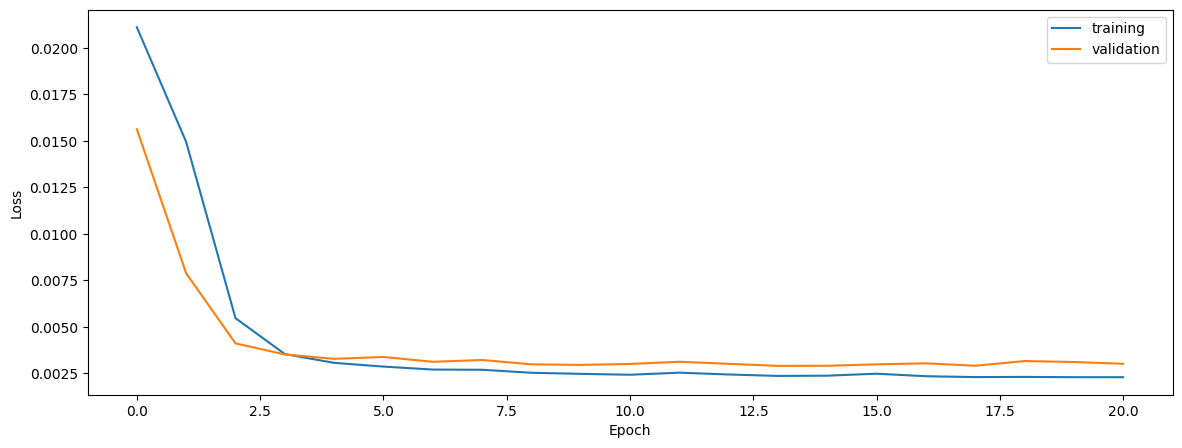

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9295332506039106
0.9062976607451784
0.9352915768168946


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9295332506039106
0.9062976607451784
0.9352915768168946


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.932896316224399
0.91956533508403
0.9350110374568549


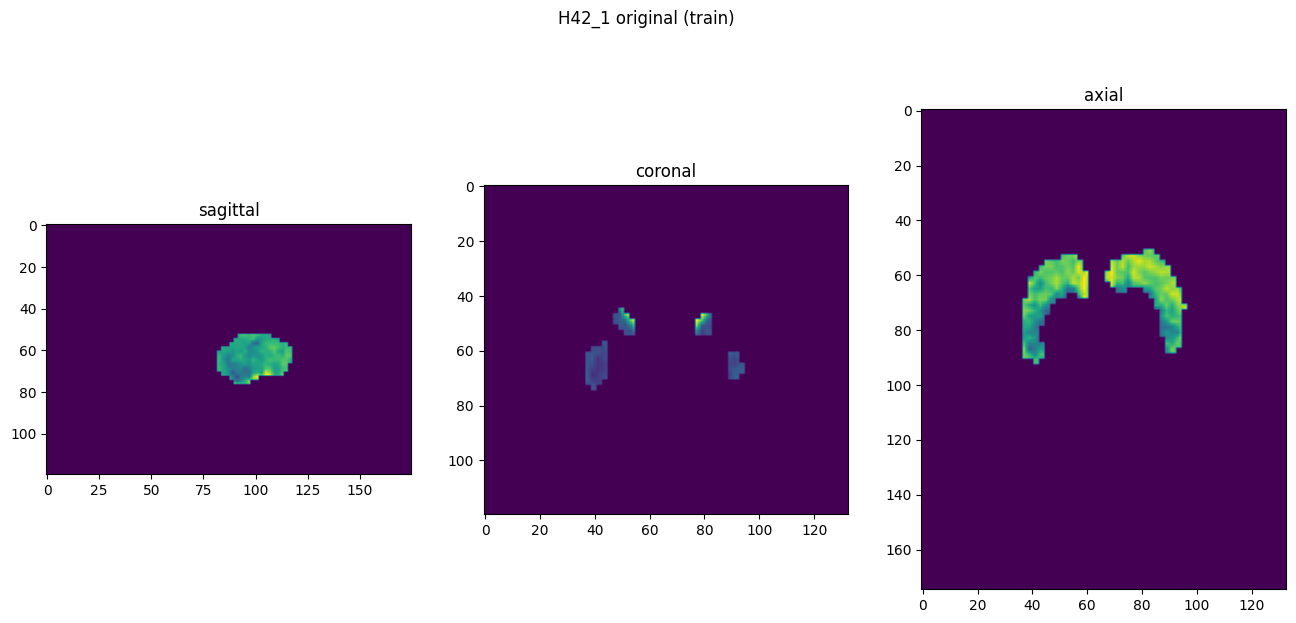

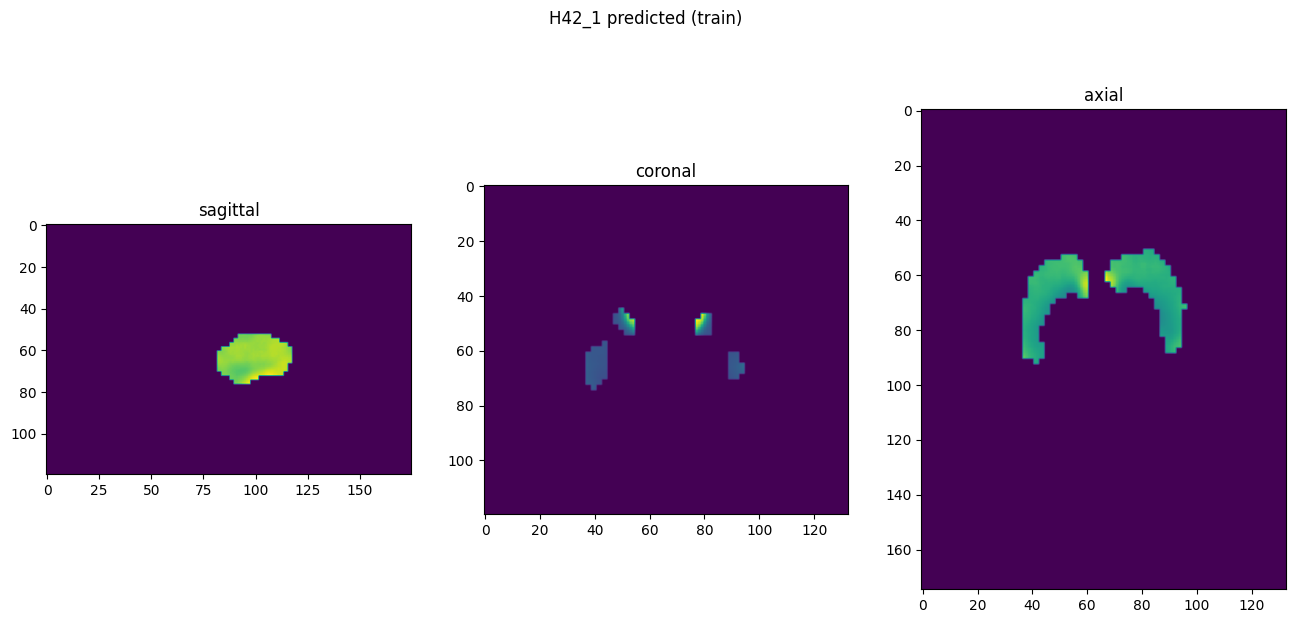

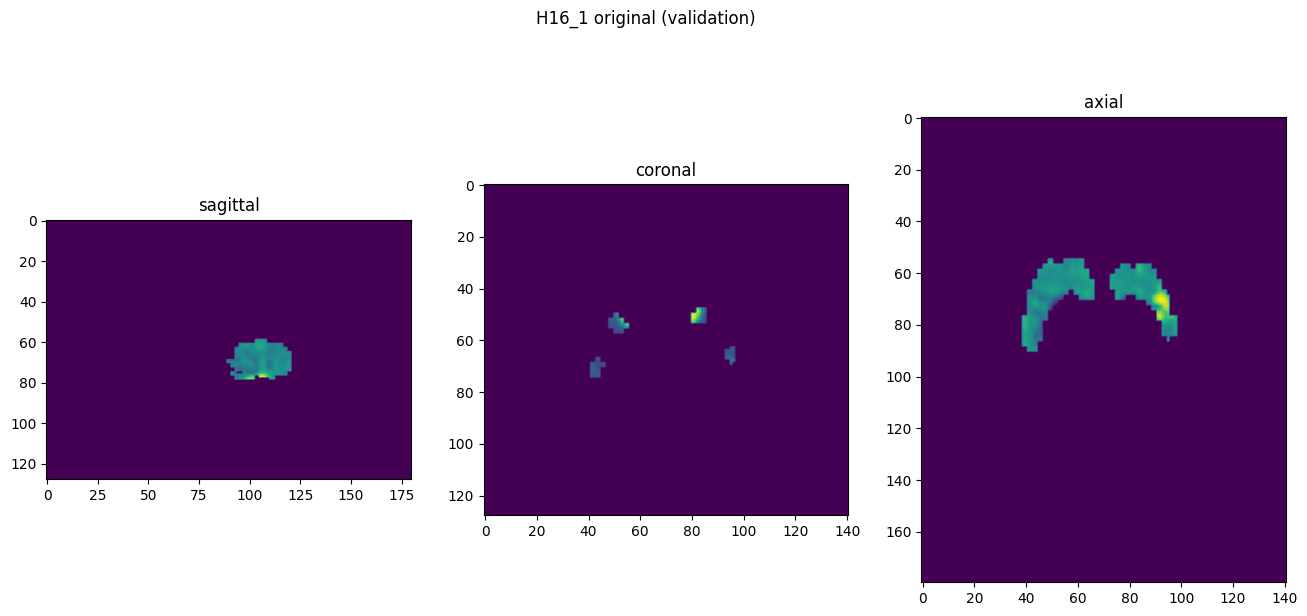

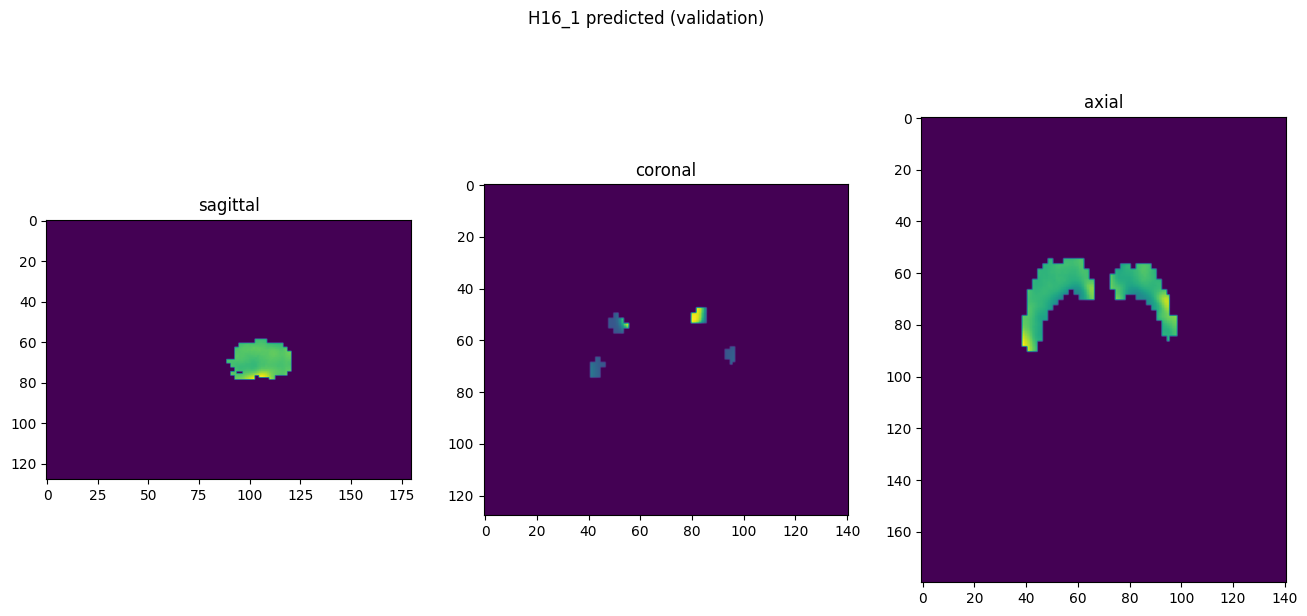

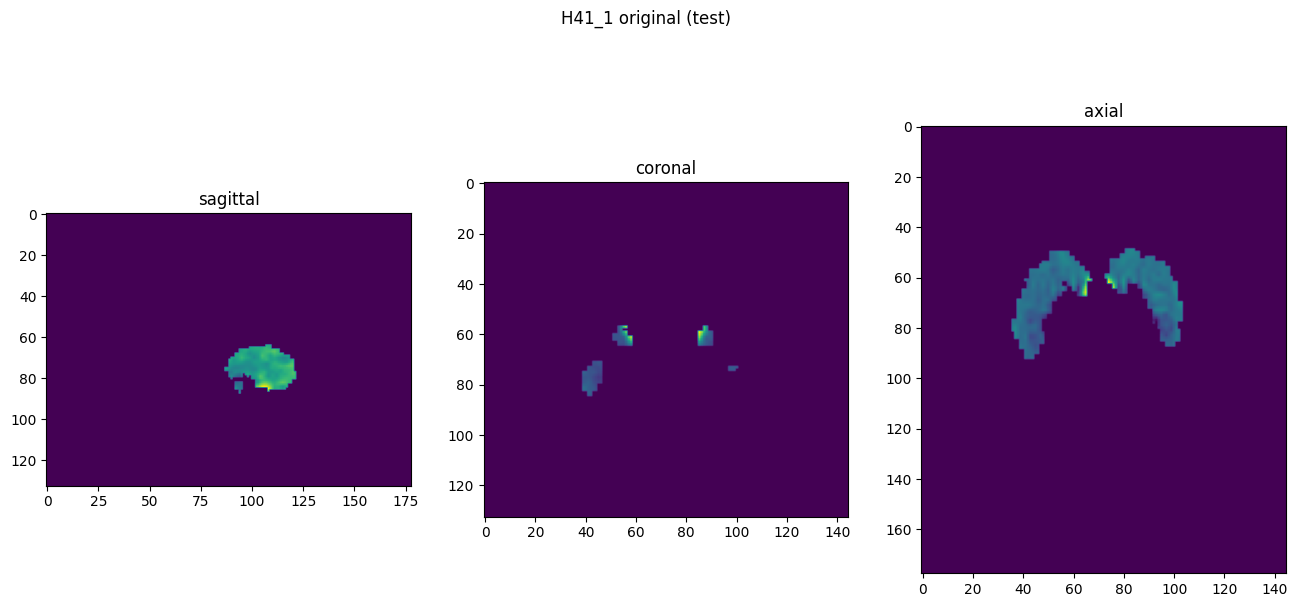

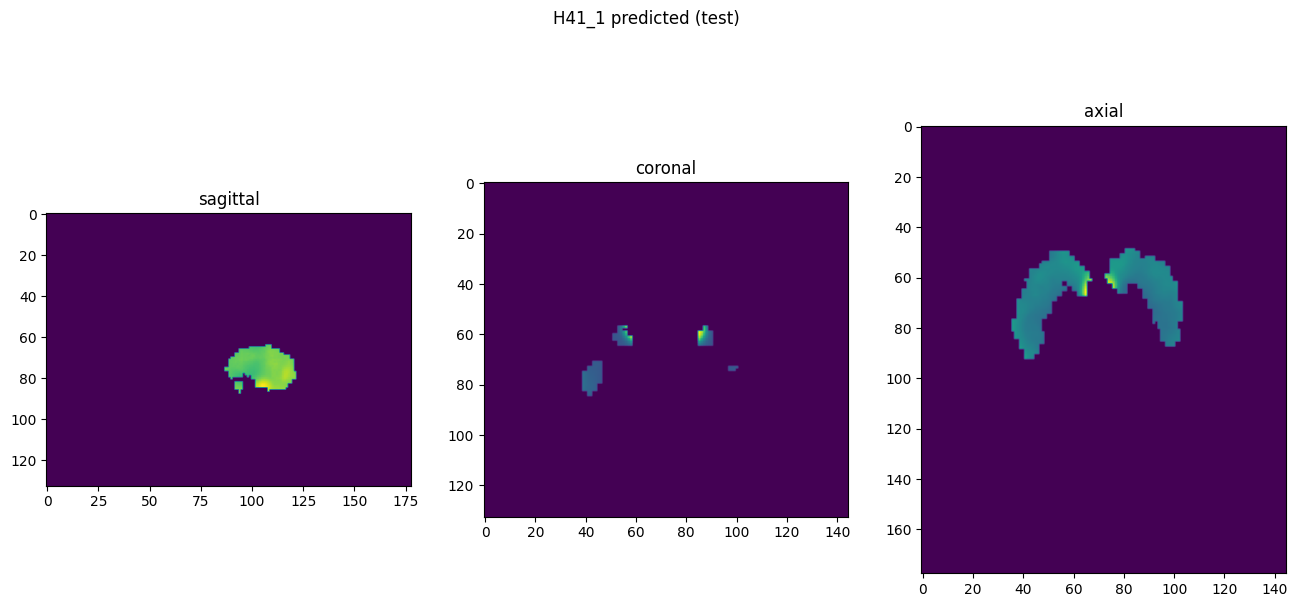

In [10]:
showResults(model, gen, threshold=None, background=False)